In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt


import xarray 
import matplotlib as mpl



#warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
#############################################################
os.chdir('D:/Xanthos-Repo/Data')

basinName = pd.read_csv('BasinNames235.txt')
basin_id = pd.read_csv('basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv('GRDC_stations_list.csv')
grdc_basin_m3persec  =  pd.read_csv('grdc_91basin_m3persec_1971_1990_monthly.csv')

basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_91 = [basinName['Basin_Name'][basins91[ii] - 1] for ii in range(GRDC_xanthosCoordIndx.shape[0])]

In [3]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

## Release

In [4]:
import xarray
os.chdir('D:\XanthosDev\example\input\calibration')
reservoirs_halfDegree = xarray.open_dataset('Xanthos_reservoirs_halfDegree_global.nc')
ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values

# directory for reservoir release data
file_dir_hp = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\reservoirRelease\\'
file_dir_fc = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-FC\\reservoirRelease\\'

for jj in range(len(basins91)):
    # get grids u/s of GRDC site
    basin_num = basins91[jj]
    dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[capac_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'ReservoirsRelease_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'ReservoirsRelease_' + str(basin_num) + '.npy')   

    # compute KGE between the two
    kge_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    for ii in range(indx_basin.shape[0]):
        mm = indx_basin[ii]
        # with hydropower
        rsim_hp= data_basin_hp[mm,:]
        # with flood control
        rsim_fc= data_basin_fc[mm,:]
        #plt.show()
        kge_hpfc[ii] = spotpy.objectivefunctions.nashsutcliffe(rsim_fc[0:240], rsim_hp[0:240])#/np.mean(rsim_fc[0:240])
        r2_hpfc[ii] = spotpy.objectivefunctions.rsquared(rsim_fc[0:240], rsim_hp[0:240])

    kge_hpfc_df_release = pd.DataFrame()
    kge_hpfc_df_release['Lon'] = Lon_HP
    kge_hpfc_df_release['Lat'] = Lat_HP

    kge_hpfc[kge_hpfc  < -1] = -1 #for colorbar purpose only
    kge_hpfc_df_release['NRMSE'] = kge_hpfc
    kge_hpfc_df_release['R2'] = r2_hpfc
    if jj==0:
        kge_hpfc_all_release = kge_hpfc_df_release
    else:
        kge_hpfc_all_release = pd.concat([kge_hpfc_all_release, kge_hpfc_df_release],0)


#### Storage 

In [5]:
import xarray
os.chdir('D:\XanthosDev\example\input\calibration')
reservoirs_halfDegree = xarray.open_dataset('Xanthos_reservoirs_halfDegree_global.nc')
ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values

# directory for reservoir release data
file_dir_hp = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\reservoir\\'
file_dir_fc = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-FC\\reservoir\\'

for jj in range(len(basins91)):
    # get grids u/s of GRDC site
    basin_num = basins91[jj]
    dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[capac_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'SimReservoirs_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'SimReservoirs_' + str(basin_num) + '.npy')   

    # compute KGE between the two
    kge_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    for ii in range(indx_basin.shape[0]):
        mm = indx_basin[ii]
        # with hydropower
        rsim_hp= data_basin_hp[mm,:]*1e-6
        # with flood control
        rsim_fc= data_basin_fc[mm,:]*1e-6
        #plt.show()
        kge_hpfc[ii] = spotpy.objectivefunctions.nashsutcliffe(rsim_fc[0:240], rsim_hp[0:240])#/np.mean(rsim_fc[0:240])
        r2_hpfc[ii] = spotpy.objectivefunctions.rsquared(rsim_fc[0:240], rsim_hp[0:240])

    kge_hpfc_df_storage = pd.DataFrame()
    kge_hpfc_df_storage['Lon'] = Lon_HP
    kge_hpfc_df_storage['Lat'] = Lat_HP

    kge_hpfc[kge_hpfc  <-1] = -1 #for colorbar purpose only
    kge_hpfc_df_storage['NRMSE'] = kge_hpfc
    kge_hpfc_df_storage['R2'] = r2_hpfc
    if jj==0:
        kge_hpfc_all_storage = kge_hpfc_df_storage
    else:
        kge_hpfc_all_storage = pd.concat([kge_hpfc_all_storage, kge_hpfc_df_storage],0)


In [6]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 

CRS = "EPSG:4326"
## Ploting
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,}

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
global_shape = gpd.GeoDataFrame(geometry=world.geometry, crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

### example Basin 48

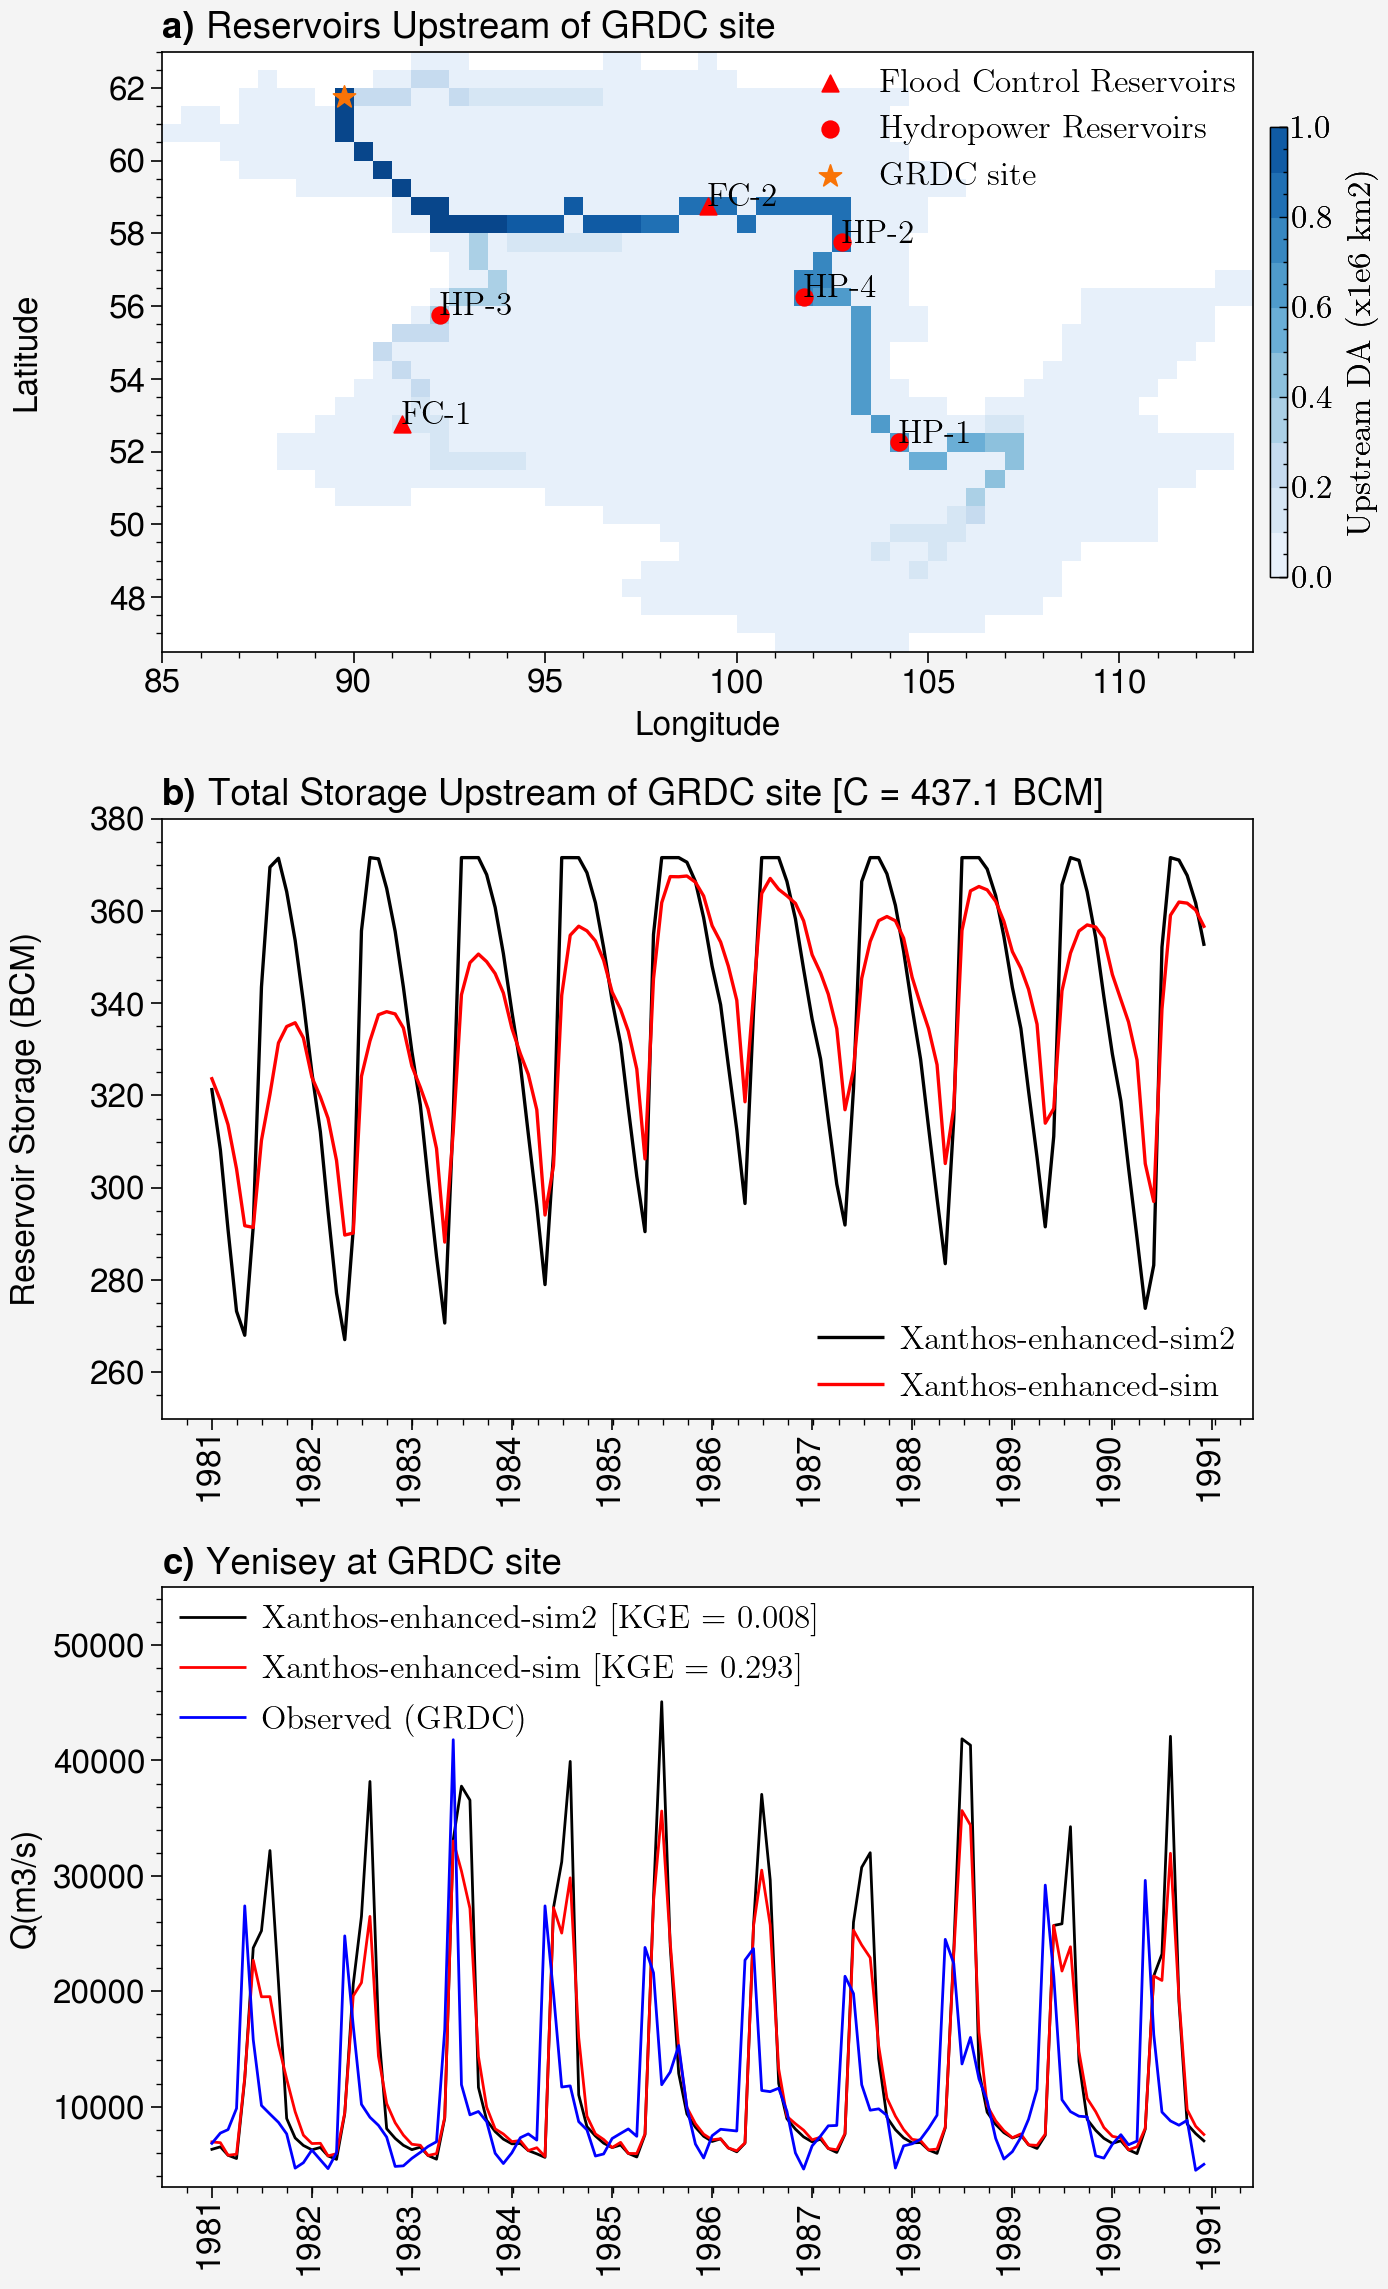

In [7]:
# get grids u/s of GRDC site
basin_num = 48
dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
basin_idx = np.squeeze(datad) 
basin_idx = basin_idx[basin_idx>0]
# reservoirs properties for grids u/s of GRDC sites
ppose_allgrid = ppose[basin_idx]
capac_allgrid = Capacity[basin_idx]
Lon_allgrids = Lon[basin_idx]
Lat_allgrdis = Lat[basin_idx]
da_allgrids = Xanthos_Catch_SKM[basin_idx]
# reservoir grids
ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
capac_basin = capac_allgrid[(ppose_allgrid>0)]
Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

# get HP reservoirs grid us/s for GRDC
ppose_HP = ppose_basin[ppose_basin==1]
capac_HP = capac_basin[ppose_basin==1]
Lon_HP = Lon_basin[ppose_basin==1]
Lat_HP = Lat_basin[ppose_basin==1]
indxHp = np.argsort(capac_HP)
# get FC reservoirs grid us/s for GRDC
ppose_FC = ppose_basin[ppose_basin==3]
capac_FC = capac_basin[ppose_basin==3]
Lon_FC = Lon_basin[ppose_basin==3]
Lat_FC = Lat_basin[ppose_basin==3]
indxFC = np.argsort(capac_FC)

# get FC reservoirs grid us/s for GRDC
ppose_IRR = ppose_basin[ppose_basin==2]
capac_IRR = capac_basin[ppose_basin==2]
Lon_IRR = Lon_basin[ppose_basin==2]
Lat_IRR = Lat_basin[ppose_basin==2]


capac_all = capac_basin[((ppose_basin==1) | (ppose_basin==3))]*1e-3 #BCM
## GRDC location
gage_site = GRDC_xanthosCoordIndx[GRDC_xanthosCoordIndx['basins']==48].reset_index(drop=True)

fig, axs = pplt.subplots(ncols=1, nrows=3, refheight=3.0, refwidth=5.0, share=0, journal='pnas3')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    ax = axs[0]
    #####################################
    # make xarraya for drainage area plot
    latxy, longxy = np.meshgrid(np.unique(Lat_allgrdis), np.unique(Lon_allgrids))
    area_remap = np.ones_like(latxy)*np.nan
    for ii in range(latxy.shape[0]):
        for jj in range(latxy.shape[1]):
            aa = np.where((Lon_allgrids == longxy[ii,jj]) & (Lat_allgrdis == latxy[ii,jj]))[0]
            if len(aa) > 0:
                area_remap[ii,jj] = da_allgrids[aa]*1e-6 #skm

    ########## save   
    function_parameters = xarray.Dataset( coords={'lon': (['x', 'y'], longxy),'lat': (['x', 'y'], latxy)})
    ##parameters
    function_parameters["DA"] =(['x', 'y'],  area_remap, {'units' :'km2', 'long_name' :'Drainage area ', '_FillvALUE' :-9999.0})


    levelsx = np.arange(0, 1.001, 0.2)
    #coastlines.plot(ax=ax, color='k', linewidth=0.1)
    function_parameters.DA.plot(x="lon", y="lat",vmin=0, vmax=1.0,
                                    col_wrap=4, 
                                    robust = True,                                   
                                    cmap='Blues',
                                    levels=11,
                                    cbar_kwargs={'shrink': 0.75,
                                    "extend":"both",
                                    "label": 'Upstream DA (x1e6 km2)',
                                    "orientation": "vertical",
                                    "aspect": 0.75,"ticks":levelsx, 
                                    "location":"lr",'width':'0.5em'
                                    }, 
                                    ax=ax)

    #m= ax.scatter(Lon_allgrids,Lat_allgrdis, 30, da_allgrids*1e-6, cmap='dusk',
    #                colorbar_kw={'length': 10, 'label': 'Upstream DA (Sqkm)'})
    #plt.colorbar()
    ax.scatter(Lon_FC, Lat_FC, c='r', marker = "^", label='Flood Control Reservoirs')
    n = ['FC-1', 'FC-2']
    lonfc = Lon_FC[indxFC]
    latfc = Lat_FC[indxFC]
    for i, txt in enumerate(n):
        ax.annotate(txt, (lonfc[i], latfc[i]))

    ax.scatter(Lon_HP, Lat_HP, c='r', label='Hydropower Reservoirs')
    n = ['HP-1', 'HP-2', 'HP-3', 'HP-4']
    lonhp = Lon_HP[indxHp]
    lathp = Lat_HP[indxHp]    
    for i, txt in enumerate(n):
        ax.annotate(txt, (lonhp[i], lathp[i]))    
    #ax.scatter(Lon_IRR, Lat_IRR, c='g', label='Irrigation Reservoir')
    ax.scatter(gage_site['lon_adj'][0], gage_site['lat_adj'][0], s=70,c='orange', marker='*',label='GRDC site')
    ax.legend(ncols=1, loc='ur')
    #ax.colorbar(m, loc='ll', label='Upstream DA *1e6 (Sqkm)') 
    ax.format(ylabel = 'Latitude', xlabel = 'Longitude',title='Reservoirs Upstream of GRDC site', grid=False, abcstyle='a)', titleloc='l', fontsize=12)

    #####################    #####################    #####################
    # Basin storage
    file_dir_hp = 'D:\\Xanthos-Repo\\Data\\Simulated\\SimulatedFinal-HPx\\reservoir\\'
    file_dir_fc = 'D:\\Xanthos-Repo\\Data\\Simulated\\SimulatedFinal-FCx\\reservoir\\'

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'SimReservoirs_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'SimReservoirs_' + str(basin_num) + '.npy')  

    # total hydropower storage US of GRDC
    data_basin_fc_total = np.sum(data_basin_fc,0)
    data_basin_hp_total = np.sum(data_basin_hp,0)

    # with hydropower
    rsim_hp= data_basin_hp_total*1e-9
    rsim_HPts = timeseries_coverter(rsim_hp[120:240], start_yr=1981, ending_yr=1990)
    # with flood control
    rsim_fc= data_basin_fc_total*1e-9
    rsim_FCts = timeseries_coverter(rsim_fc[120:240], start_yr=1981, ending_yr=1990)
    
    # plot
    ax=axs[1]
    ax.plot(rsim_FCts, 'k', linewidth=1.2, label='Xanthos-enhanced-sim2')
    ax.plot(rsim_HPts,'red', linewidth=1.2, linestyle='-', label='Xanthos-enhanced-sim')  
    ax.format(ylabel = 'Reservoir Storage (BCM)', title='Total Storage Upstream of GRDC site [' + 'C = ' +str(sum(capac_all)) +' BCM]', grid=False, abcstyle='a)', titleloc='l', fontsize=12)
    ax.legend(ncols=1, loc='best')
    ax.set_ylim([250,380])

    ########################    #####################    #####################
    #GRDC flow
    ax = axs[2]
    # GRDC station
    
    file_dir_watch_hp = 'D:\\Xanthos-Repo\\Data\\Simulated\\SimulatedFinal-HPx\\flow\\'
    file_dir_watch_fc = 'D:\\Xanthos-Repo\\Data\\Simulated\\SimulatedFinal-FCx\\flow\\'
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
    qobs_calibration= grdc_m3persec[120:240]
    grdc_ts = timeseries_coverter(qobs_calibration, start_yr=1981, ending_yr=1990)

    ## simulated
    data_basin = np.load(file_dir_watch_hp + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_hp= data_basin[120:240]
    qsim_HP_ts = timeseries_coverter(qsim_hp, start_yr=1981, ending_yr=1990)

    ## Natural
    data_basin_yl = np.load(file_dir_watch_fc + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_fc = data_basin_yl[120:240]
    qsim_FC_ts = timeseries_coverter(qsim_fc, start_yr=1981, ending_yr=1990)

    # KGE
    kge_fc = spotpy.objectivefunctions.kge(qobs_calibration, qsim_fc) 
    kge_hp = spotpy.objectivefunctions.kge(qobs_calibration, qsim_hp) 
    ii = np.where(basins91==basin_num)[0][0]
    # plotting
    ax.plot(qsim_FC_ts, 'k', label='Xanthos-enhanced-sim2 [KGE = ' + str(np.round(kge_fc,3)) + ']')
    ax.plot(qsim_HP_ts, 'r', label='Xanthos-enhanced-sim [KGE = ' + str(np.round(kge_hp,3)) + ']')
    ax.plot(grdc_ts, 'b', label='Observed (GRDC)')
    ax.format(ylabel = 'Q(m3/s)', title = basinName_91[ii])
    ax.format(ylabel = 'Q(m3/s)', title = basinName_91[ii] + ' at GRDC site', grid=False, abcstyle='a)', titleloc='l', fontsize=12)
    ax.set_ylim([3000,55000])
    ax.legend(ncols=1)

fig.align_ylabels(axs)
plt.tight_layout()

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig(dir_out + "Figure-14.png", **SAVE_KWDS)         